In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS315, set up the annotation of the nucleosome areas

## Wildtype

In [2]:
load_dir =  "ARS315"

In [3]:
ls ARS315/

ARS315 updated FINAL.fa
ARS315_80bp.txt
ARS315_disw2_rep1_780READS_noNA.csv
ARS315_disw2_rep2_780READS_noNA.csv
ARS315_feature_methylation_annotation_v3.csv
ARS315_feature_methylation_window30_union_selected.csv
ARS315_feature_methylation_window50_selected.csv
ARS315_p_values_avg_feature_methylation.csv
ARS315_pooled_samples_two-sided-test.csv
ARS315_separate_replicates_two-sided-test.csv
DIES6_ALL_REP1_ARS315_starting_LexA.txt
DIES6_ARS315_REP2_780READS.csv
Features from ARS315_starting_LexA  (31 .. 1277).txt
coordinates_ARS315.txt
coordinates_ARS315_v4.csv
mat_Megalodon_repII_ARS315_cleaned.txt
mat_Megalodon_repII_ARS315_starting_LexA.txt
plot_data/
plots/
reverse/
unused_files/
wt_mat_Megalodon_repIII_ARS315_starting_LexA.txt


In [4]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS315_starting_LexA.txt")

#replicate 2

#rep2_raw = np.genfromtxt("ARS315/mat_Megalodon_repII_ARS315_starting_LexA.txt", delimiter = "\t")
#rep2_raw.shape #1236, 1238 
#np.where(np.isnan(rep2_raw[:, 1])) #smallest value is 697
##select the first 697 rows and save as a separate file
#np.savetxt("ARS315/mat_Megalodon_repII_ARS315_cleaned.txt", rep2_raw[:697,:1236])

wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS315_cleaned.txt")

In [5]:
##feature annotation

##anno = pd.read_csv(load_dir + "/Features from ARS315_starting_LexA  (31 .. 1277).txt", sep  = "\t", 
##                          header = None, index_col = 0)
##anno.columns = ["position", "length"]

##anno = pd.read_csv(load_dir + "/coordinates_ARS315.txt", sep  = "\t", 
##                          header = None, index_col = 0)

##Third version of annotation with nucleosomal areas and linker
#anno = pd.read_csv(load_dir + "/ARS315_80bp.txt", sep  = "\t", 
#                          header = None, index_col = 0)

##Fourth Version of annotation:
##anno = pd.read_csv(load_dir + "/coordinates_ARS315_v4.csv", sep  = ",", 
##                          header = None, index_col = 0)
#anno.columns = ["position"]

#anno.index = anno.index.astype("string")
#anno.index = anno.index.str.strip()

#anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
#anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

#anno["length"] = anno.pos_stop - anno.pos_start

In [6]:
#anno.rename(index = {"+3ns" : "ns+3",
#                   "prom":"prom",
#                   "+2ns": "ns+2", 
#                   "+1L" : "L+1",
#                   "+1ns": "ns+1",
#                   "ARS315": "ARS315",
#                   "-1NS": "ns-1",
#                   "-2 NS":"ns-2",
#                   "-1 L":"L-1"}, inplace = True)
#anno.index

## An alternative approach to predefined features would be to divide the locus into a number of windows with fixed sizes. Start with a window size of 100 nt and test the effect on clustering

In [7]:
## an alternative approach to predefined features would be to divide the 
#locus into a number of windows with fixed sizes. Start with a window size of 100 nt and 
# test the effect on clustering 

windowsize = 30


d = {"pos_start":list(range(0, wt_rep3.shape[1], windowsize)),
            "pos_stop":list(range((windowsize -1) , wt_rep3.shape[1], windowsize)) + [wt_rep3.shape[1]]}
anno = pd.DataFrame(d,
            index = list(range(1, wt_rep3.shape[1]//windowsize + 2)))
anno["length"] = (anno.pos_stop +1) - anno.pos_start

anno["position"] = "x"
anno.head()

,pos_start,pos_stop,length,position
1,0,29,30,x
2,30,59,30,x
3,60,89,30,x
4,90,119,30,x
5,120,149,30,x


In [8]:
#Load methylation data for the reverse strand:

wt_rep3_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repIII_ARS315_starting_LexA_minus.txt")
wt_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repII_ARS315_starting_LexA_minus.txt")

dies6_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_ARS315_starting_LexA_minus.txt")
dies6_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_ARS315_starting_LexA_minus.txt")

disw2_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_ARS315_starting_LexA_minus.txt")
disw2_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_ARS315_starting_LexA_minus.txt")

In [9]:
print(wt_rep2.shape[1] == wt_rep3.shape[1])
print(wt_rep3_rev.shape[0] == wt_rep3.shape[0])
print(wt_rep2_rev.shape, wt_rep2.shape)

True
True
(780, 1237) (697, 1236)


In [10]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

wt_rep3_join = np.concatenate((wt_rep3, wt_rep3_rev[:, :-1]), axis = 0)
#subsample wt_rep2_rev to 697 reads
wt_rep2_rev_sub = subsample(wt_rep2_rev, 697)
wt_rep2_join = np.concatenate((wt_rep2, wt_rep2_rev_sub[:, :-1]), axis = 0)

wt_rep3 = wt_rep3_join
wt_rep2 = wt_rep2_join

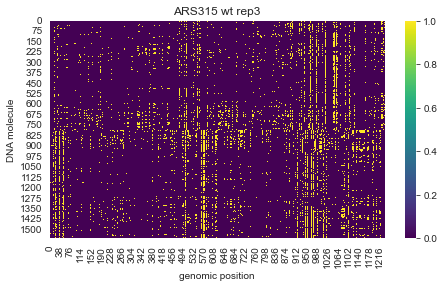

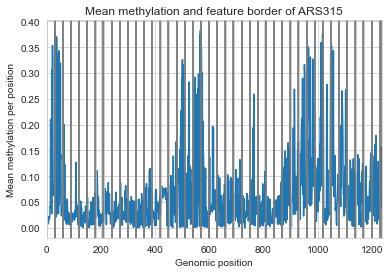

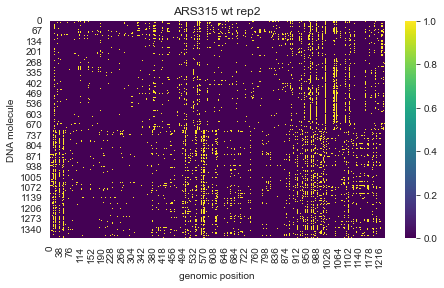

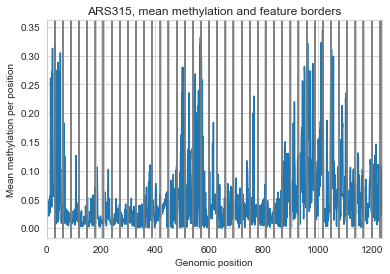

In [11]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

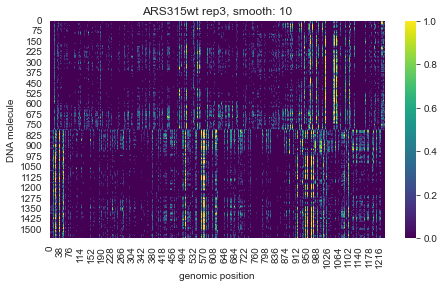

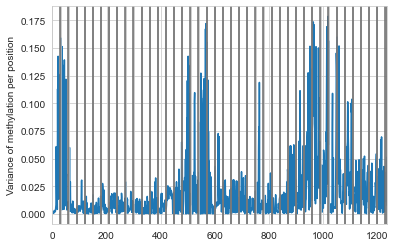

In [12]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [13]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([ 1.94174757,  0.80906149,  1.21359223, ..., 14.0776699 ,
       19.82200647,  4.77346278])

In [14]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

<AxesSubplot:title={'center':'ARS315 wt rep3, entropy per position'}, ylabel='entropy'>

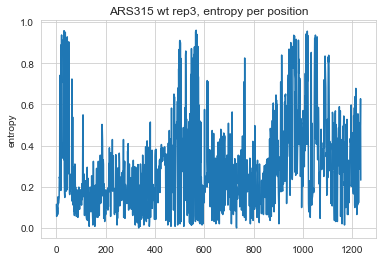

In [15]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [16]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.9599213421545211, 1234)

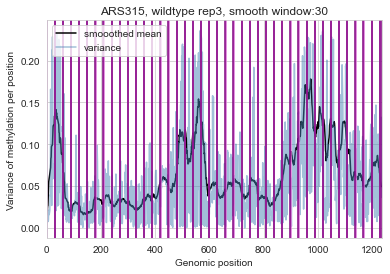

In [17]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  ", wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

In [18]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS315_starting_LexA.txt")
print(dies6_rep1.shape, dies6_rep1_rev.shape)

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS315_REP2_780READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape, dies6_rep2_rev.shape)

(780, 1236) (780, 1237)
(780, 1236) (780, 1237)


In [19]:
#join the plus and minus strand, no subsampling
dies6_rep1_join = np.concatenate((dies6_rep1, dies6_rep1_rev[:, :-1]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2, dies6_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

dies6_rep1 = dies6_rep1_join.copy()
dies6_rep2 = dies6_rep2_join.copy()

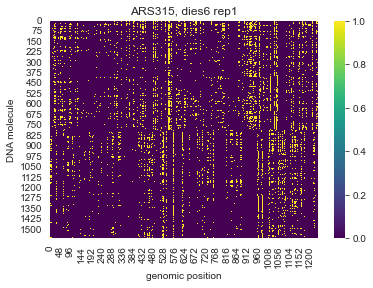

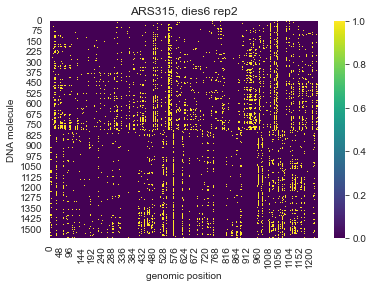

In [20]:
sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

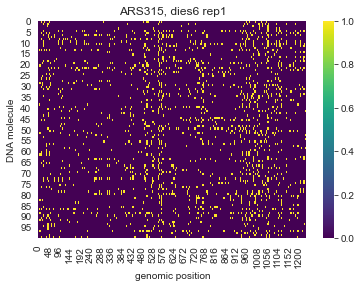

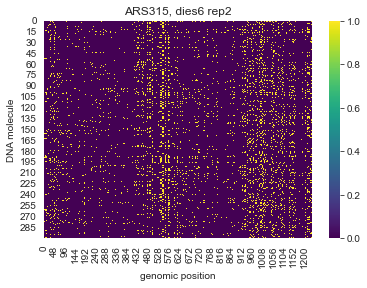

In [21]:
#subsample to the same number of molecules than in 316
#rep1 -> 83
#rep2 -> 301

def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

test1 = subsample(dies6_rep1, 100)
test2 = subsample(dies6_rep2, 300)

sns.heatmap(test1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(test2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

In [22]:
#dies6_rep1 = subsample(dies6_rep1, 83)
#dies6_rep2 = subsample(dies6_rep2, 301)

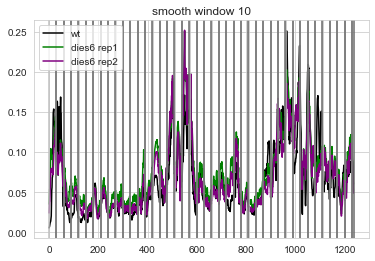

(137640.0, 1.4171724992925624e-84)

In [23]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [24]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=118668.5, pvalue=2.7738132379189148e-90)

## Load data for mutant disw2

In [25]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS315_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape, disw2_rep1_rev.shape)

disw2_rep2 = np.genfromtxt(load_dir + "/ARS315_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
print(disw2_rep2.shape, disw2_rep2_rev.shape)

(780, 1236) (780, 1237)
(780, 1236) (780, 1237)


In [26]:
#join the plus and minus strand, no subsampling here

disw2_rep1_join = np.concatenate((disw2_rep1, disw2_rep1_rev[:, :-1]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2, disw2_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

disw2_rep1 = disw2_rep1_join.copy()
disw2_rep2 = disw2_rep2_join.copy()

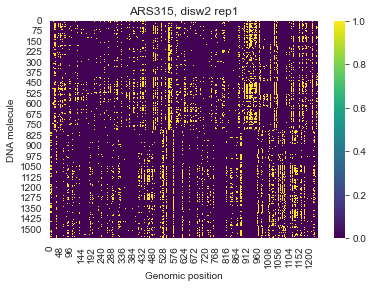

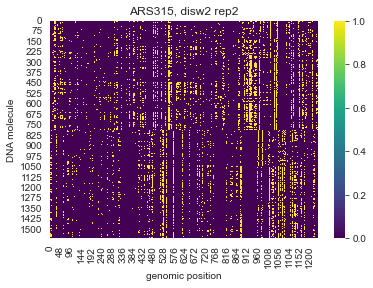

In [27]:
sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()


sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

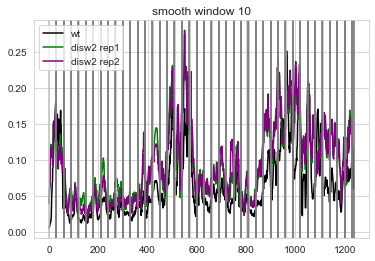

In [28]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [29]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(355832.0, 0.7470439131407984)

In [30]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1236.0,0.064448,0.070022,0.0,0.020513,0.042949,0.080769,0.382692,1560
wt_rep2,1236.0,0.051675,0.060361,0.0,0.014347,0.031564,0.062410,0.344333,1394
dies6_rep1,1236.0,0.076884,0.069479,0.0,0.022276,0.062821,0.107051,0.389744,1560
dies6_rep2,1236.0,0.068379,0.068316,0.0,0.017308,0.050000,0.092949,0.396154,1560
disw2_rep1,1236.0,0.095764,0.088852,0.0,0.018429,0.078526,0.139744,0.421795,1560
disw2_rep2,1236.0,0.095653,0.089790,0.0,0.021795,0.071474,0.137340,0.423718,1560


## Min-max normalise each experiment and pool replicates

In [31]:
"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""


#normalise to the nucleosomal array spike-ins
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)



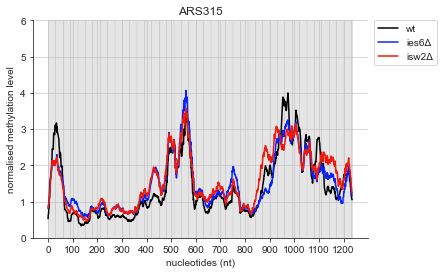

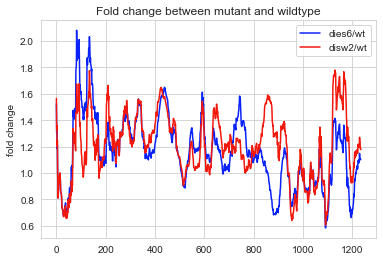

In [32]:
N=30

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        for feature in anno.index:
            plt.fill_betweenx(range(0,7), 
                      anno.loc[feature, "pos_start"],
                      anno.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS315_smoothed_profiles_wt_mut_revision.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#0a22fa", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#f2180c",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
#plt.savefig("ARS315/plots/ARS315_fold_changes.png", dpi = 300)
plt.show()

### Compare mean distributions between pooled replicates and pooled wildtype with paired wilcoxon test

In [33]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [34]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [35]:
#segments.to_csv(load_dir + "/ARS315_pooled_samples_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,29,30,0.495789,0.393040
2,30,59,30,0.393040,0.495789
3,60,89,30,0.022534,0.052956
4,90,119,30,0.004775,0.657566
5,120,149,30,0.000026,0.002558
6,150,179,30,0.003162,0.442711
7,180,209,30,0.169730,0.176551
8,210,239,30,0.156682,0.144409
9,240,269,30,0.294305,0.405131
10,270,299,30,0.000519,0.000442


In [36]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in both mutants compared to wildtype?")
print("       P-value below: ", pvalue)
significant = segments.loc[(segments["p_value_dies6"] < pvalue) | (segments["p_value_disw2"] < pvalue)]
significant

       Which sites have a different mean methylation in both mutants compared to wildtype?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
3,60,89,30,0.022534,0.052956
4,90,119,30,0.004775,0.657566
5,120,149,30,0.000026,0.002558
6,150,179,30,0.003162,0.442711
10,270,299,30,0.000519,0.000442
12,330,359,30,0.001137,0.002558
14,390,419,30,0.002061,0.000345
15,420,449,30,0.000005,0.000005
16,450,479,30,0.011765,0.004775
19,540,569,30,0.002381,0.122090


In [37]:
##Regions significant for disw2:
#print("       Which sites have a different mean methylation in the disw2 mutant?")
#print("       P-value below: ", pvalue)
#segments.loc[(segments["p_value_disw2"] < pvalue)]

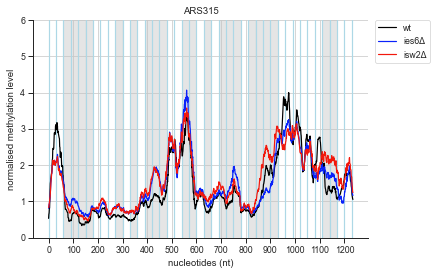

In [38]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS315_smoothed_profiles_revision_window30_selection_union.svg", dpi=300, bbox_inches = "tight")
        plt.show()

## Condense segment information for statistical testing of methylation per feature window
### Compare pooled wildtype to mutant replicates, then filter regions

In [39]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [40]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

In [41]:
#segments.to_csv(load_dir + "/ARS315_separate_replicates_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
1,0,29,30,0.405131,0.626597,0.429968,0.393040
2,30,59,30,0.429968,0.369525,0.626597,0.393040
3,60,89,30,0.022534,0.020099,0.035008,0.085606
4,90,119,30,0.020099,0.001916,0.596272,0.803619
5,120,149,30,0.000055,0.000009,0.002061,0.004463
6,150,179,30,0.016878,0.000087,0.265453,0.455667
7,180,209,30,0.238611,0.221817,0.078020,0.314666
8,210,239,30,0.127400,0.256284,0.111991,0.256284
9,240,269,30,0.274846,0.611351,0.455667,0.358103
10,270,299,30,0.000714,0.000519,0.000292,0.000835


In [42]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
3,60,89,30,0.022534,0.020099,0.035008,0.085606
4,90,119,30,0.020099,0.001916,0.596272,0.803619
5,120,149,30,0.000055,0.000009,0.002061,0.004463
6,150,179,30,0.016878,0.000087,0.265453,0.455667
10,270,299,30,0.000714,0.000519,0.000292,0.000835
12,330,359,30,0.000176,0.011062,0.001323,0.006653
14,390,419,30,0.001536,0.008077,0.002381,0.000148
15,420,449,30,0.000003,0.000005,0.000005,0.000005
16,450,479,30,0.009171,0.012508,0.018970,0.002558
19,540,569,30,0.012505,0.000714,0.132887,0.089617


In [43]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
5,120,149,30,0.000055,0.000009,0.002061,0.004463
10,270,299,30,0.000714,0.000519,0.000292,0.000835
12,330,359,30,0.000176,0.011062,0.001323,0.006653
14,390,419,30,0.001536,0.008077,0.002381,0.000148
15,420,449,30,0.000003,0.000005,0.000005,0.000005
16,450,479,30,0.009171,0.012508,0.018970,0.002558
20,570,599,30,0.003162,0.000013,0.010397,0.005107
22,630,659,30,0.001654,0.006232,0.000563,0.000227
24,690,719,30,0.006232,0.230105,0.009171,0.003162
29,840,869,30,0.190804,0.205887,0.000269,0.000073


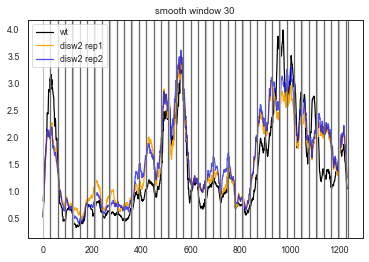

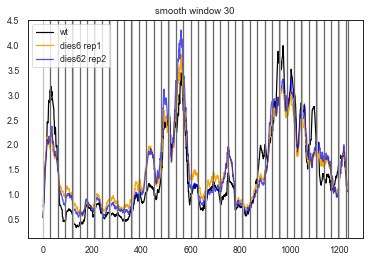

In [44]:
# How does that look over the whole sequence?
smooth_width = 30
sns.set_style("white")

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
#plt.savefig(load_dir + "/plots/ARS315_averaged_meth_disw2_replicates.png", dpi=300)
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
#plt.savefig(load_dir + "/plots/ARS315_averaged_meth_dies6_replicates.png", dpi=300)
plt.show()

In [45]:
#Repeat this test for the hypothesis that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis=1, inplace = True)

In [46]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
3,60,89,30,0.011267,0.010050,0.017504,0.042803
4,90,119,30,0.010050,0.000958,0.298136,0.401809
5,120,149,30,0.000028,0.000004,0.001030,0.002231
6,150,179,30,0.008439,0.000043,0.132727,0.227834
10,270,299,30,0.000357,0.000260,0.000146,0.000418
12,330,359,30,0.000088,0.005531,0.000661,0.003327
14,390,419,30,0.000768,0.004038,0.001191,0.000074
15,420,449,30,0.000001,0.000002,0.000002,0.000002
16,450,479,30,0.004586,0.006254,0.009485,0.001279
19,540,569,30,0.006253,0.000357,0.066444,0.044809


In [47]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
5,120,149,30,0.000028,0.000004,0.001030,0.002231
10,270,299,30,0.000357,0.000260,0.000146,0.000418
12,330,359,30,0.000088,0.005531,0.000661,0.003327
14,390,419,30,0.000768,0.004038,0.001191,0.000074
15,420,449,30,0.000001,0.000002,0.000002,0.000002
16,450,479,30,0.004586,0.006254,0.009485,0.001279
20,570,599,30,0.001581,0.000007,0.005198,0.002554
22,630,659,30,0.000827,0.003116,0.000281,0.000114
24,690,719,30,0.003116,0.115053,0.004586,0.001581
27,780,809,30,0.075225,0.247894,0.019461,0.020507


## Show the average methylation by feature for each of the conditions

In [48]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()

In [49]:
#20230214: for the fixed window size approach, only select significantly different regions
saved = anno.copy()
anno = anno.iloc[anno.index.intersection(significant.index)-1,:]

In [50]:
"""#normalize the count matrices to the max of averages of the respective sample
wt_rep3_maxnorm = max_normalise_array(wt_rep3)
wt_rep2_maxnorm = max_normalise_array(wt_rep2)

dies6_rep1_maxnorm = max_normalise_array(dies6_rep1)
dies6_rep2_maxnorm = max_normalise_array(dies6_rep2)

disw2_rep1_maxnorm = max_normalise_array(disw2_rep1)
disw2_rep2_maxnorm = max_normalise_array(disw2_rep2)
"""

#normalise the count matrices to the mean methylation frequency of the nucleosomal array spike-in controls

wt_rep3_maxnorm = wt_rep3/mean_array_wt_rep3
wt_rep2_maxnorm = wt_rep2/mean_array_wt_rep2

dies6_rep1_maxnorm = dies6_rep1/mean_array_dies6_rep1
dies6_rep2_maxnorm = dies6_rep2/mean_array_dies6_rep2

disw2_rep1_maxnorm = disw2_rep1/mean_array_disw2_rep1
disw2_rep2_maxnorm = disw2_rep2/mean_array_disw2_rep2

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


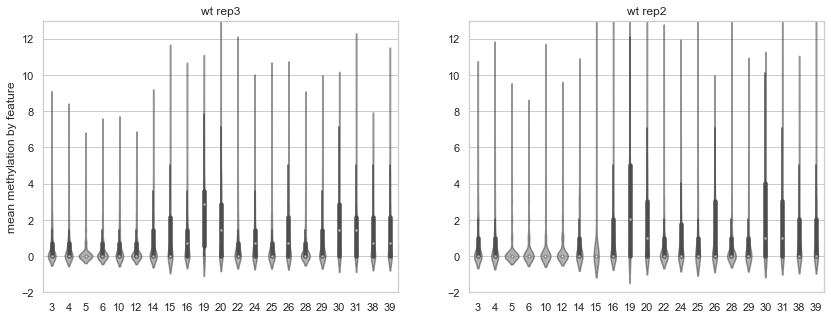

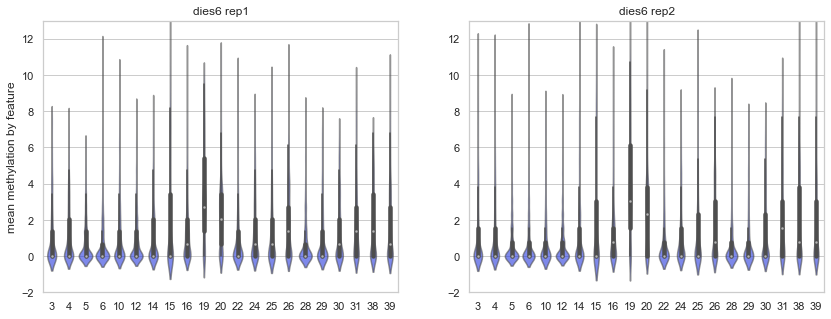

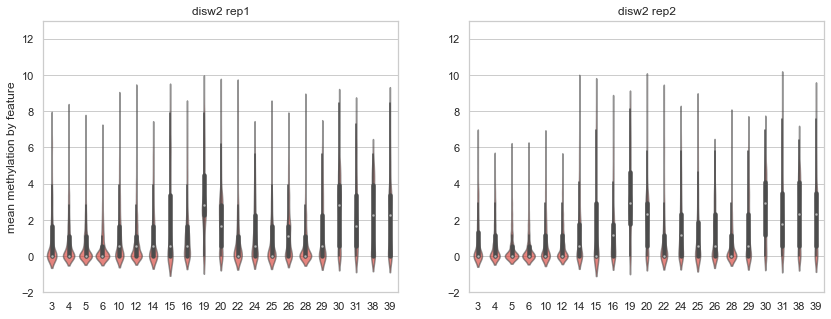

In [51]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2, 13)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2, 13)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS315_methylation_by_feature_wt_revision.svg")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2, 13)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2, 13)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS315_methylation_by_feature_dies6_revision.svg")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2, 13)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2, 13)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS315_methylation_by_feature_disw2_revision.svg")
plt.show()

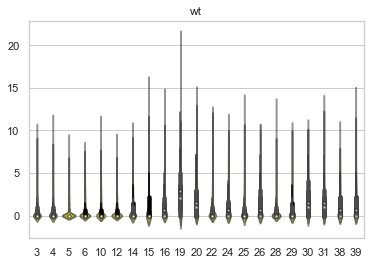

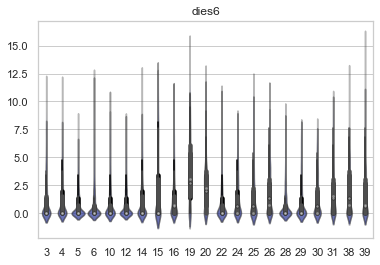

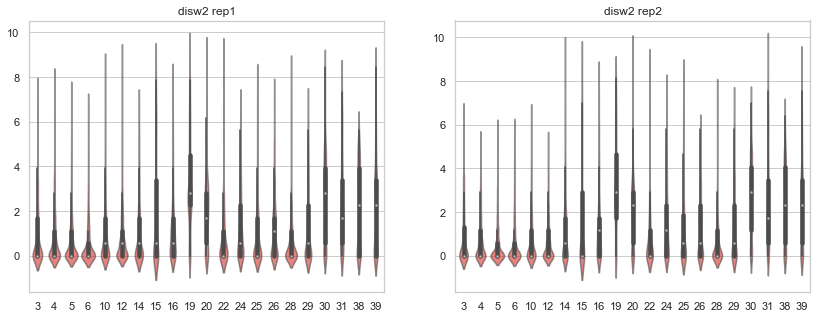

In [52]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
#wt

g = sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "black", label = "rep3")
g.set_title("wt")

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "yellow", label = "rep2")
g.set_xticklabels(anno.index)
plt.setp(g.collections, alpha = 0.6)
plt.show()

#dies6
f = sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "black")
f.set_title("dies6")

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa")
f.set_xticklabels(anno.index)
plt.setp(f.collections, alpha = 0.4)
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
plt.setp(ax2.collections, alpha = 0.6)
plt.show()

In [53]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "ies6Δ"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "ies6Δ"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "isw2Δ"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "isw2Δ"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "norm methylation"}, inplace=True)

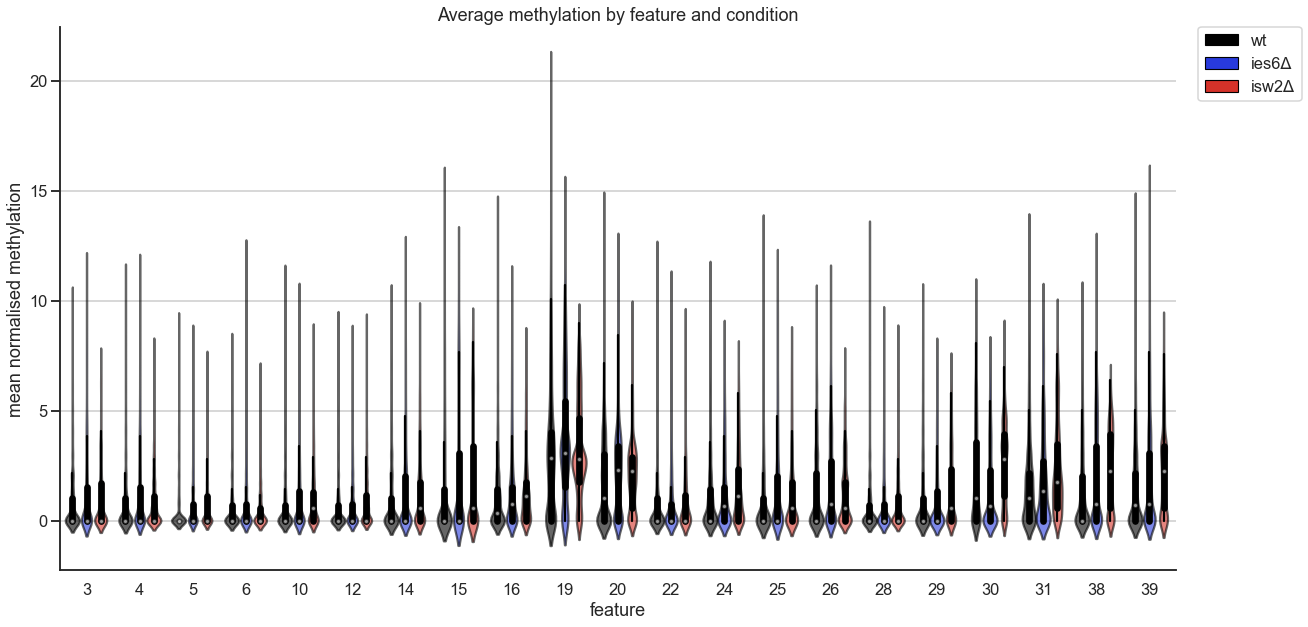

In [54]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

#sns.set(font_scale=1.5)
#sns.set_style("whitegrid")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False,
                                 'xtick.bottom': False}):
    sns.set_context("talk")
    plt.figure(figsize = (20, 10)) #(10,7))
    ax = sns.violinplot(data = methylation_rep1, x="feature", y = "norm methylation", hue = "condition", 
                    palette = col_Anna)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.setp(ax.collections, alpha = 0.6)
    plt.title("Average methylation by feature and condition")
    plt.ylabel("mean normalised methylation")
    #plt.savefig(load_dir + "/plots/ARS315_pooled_norm_av_methylation_by_feature_revision_window_30nt.svg", 
     #           dpi = 300, bbox_inches = "tight")
    plt.show()

In [55]:
#methylation_rep1.to_csv(load_dir + "/ARS315_violinplots_annotation_v3.csv")

In [56]:
#Export the data for the cluster analysis

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3["strand"] = ["plus" if i<feat_me_wt_rep3.shape[0]//2 else "minus" for i in range(feat_me_wt_rep3.shape[0])]
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt"
feat_me_wt_rep3_melt["replicate"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2["strand"] = ["plus" if i<feat_me_wt_rep2.shape[0]//2 else "minus" for i in range(feat_me_wt_rep2.shape[0])]
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt"
feat_me_wt_rep2_melt["replicate"] = "wt rep2"

#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index
feat_me_dies6_rep2["strand"] = ["plus" if i<feat_me_dies6_rep2.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep2.shape[0])]
feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"
feat_me_dies6_rep2_melt["replicate"] = "dies6 rep2"

feat_me_dies6_rep1 = pd.DataFrame(dies6_rep1_feat_me, columns = anno.index)
feat_me_dies6_rep1["molecule"] = feat_me_dies6_rep1.index
feat_me_dies6_rep1["strand"] = ["plus" if i<feat_me_dies6_rep1.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep1.shape[0])]
feat_me_dies6_rep1_melt = pd.melt(feat_me_dies6_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep1_melt["condition"] = "dies6"
feat_me_dies6_rep1_melt["replicate"] = "dies6 rep1"


#the same for disw2
feat_me_disw2_rep2 = pd.DataFrame(disw2_rep2_feat_me, columns = anno.index)
feat_me_disw2_rep2["molecule"] = feat_me_disw2_rep2.index
feat_me_disw2_rep2["strand"] = ["plus" if i<feat_me_disw2_rep2.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep2.shape[0])]
feat_me_disw2_rep2_melt = pd.melt(feat_me_disw2_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep2_melt["condition"] = "disw2"
feat_me_disw2_rep2_melt["replicate"] = "disw2 rep2"

feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index
feat_me_disw2_rep1["strand"] = ["plus" if i<feat_me_disw2_rep1.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep1.shape[0])]
feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"
feat_me_disw2_rep1_melt["replicate"] = "disw2 rep1"

#merge into one dataframe:
methylation_features = pd.concat([feat_me_wt_rep3_melt, feat_me_wt_rep2_melt, 
                                  feat_me_dies6_rep1_melt, feat_me_dies6_rep2_melt,
                                  feat_me_disw2_rep1_melt, feat_me_disw2_rep2_melt
                                 ])
methylation_features.rename(columns = {"value" : "norm_methylation"}, inplace=True)

In [57]:
#methylation_features.to_csv(load_dir + "/ARS315_feature_methylation_window30_union_selected.csv")

In [59]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

from scipy.stats import mannwhitneyu

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column == "strand")]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column == "strand")]

feature_pvalues

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
3,60,89,30,3.074553e-03,2.351240e-08
4,90,119,30,1.075651e-12,2.856924e-09
5,120,149,30,5.614207e-32,9.808412e-67
6,150,179,30,7.834858e-09,3.539235e-11
10,270,299,30,9.511176e-09,2.994125e-57
12,330,359,30,2.655693e-13,6.052948e-45
14,390,419,30,3.896050e-06,9.761167e-24
15,420,449,30,2.569894e-13,1.847338e-49
16,450,479,30,1.305858e-13,2.415627e-17
19,540,569,30,4.708666e-34,9.454351e-09


In [60]:
feature_pvalues[feature_pvalues.dies6_rep2 < 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
3,60,89,30,3.074553e-03,2.351240e-08
4,90,119,30,1.075651e-12,2.856924e-09
5,120,149,30,5.614207e-32,9.808412e-67
6,150,179,30,7.834858e-09,3.539235e-11
10,270,299,30,9.511176e-09,2.994125e-57
12,330,359,30,2.655693e-13,6.052948e-45
14,390,419,30,3.896050e-06,9.761167e-24
15,420,449,30,2.569894e-13,1.847338e-49
16,450,479,30,1.305858e-13,2.415627e-17
19,540,569,30,4.708666e-34,9.454351e-09


In [61]:
feature_pvalues[feature_pvalues.disw2_rep1 < 2.5e-2]

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
3,60,89,30,3.074553e-03,2.351240e-08
4,90,119,30,1.075651e-12,2.856924e-09
5,120,149,30,5.614207e-32,9.808412e-67
6,150,179,30,7.834858e-09,3.539235e-11
10,270,299,30,9.511176e-09,2.994125e-57
12,330,359,30,2.655693e-13,6.052948e-45
14,390,419,30,3.896050e-06,9.761167e-24
15,420,449,30,2.569894e-13,1.847338e-49
16,450,479,30,1.305858e-13,2.415627e-17
19,540,569,30,4.708666e-34,9.454351e-09


In [62]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column == "strand")]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column == "strand")]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
3,60,89,30,1.438517e-07,2.059740e-11
4,90,119,30,3.169262e-23,2.892043e-12
5,120,149,30,8.395682e-56,6.649310e-64
6,150,179,30,3.406919e-11,1.524080e-12
10,270,299,30,1.112793e-20,4.997874e-54
12,330,359,30,7.794979e-25,1.158166e-51
14,390,419,30,1.517399e-12,2.326243e-50
15,420,449,30,1.075271e-25,4.055847e-52
16,450,479,30,6.485937e-13,2.003132e-32
19,540,569,30,3.938479e-30,1.189314e-18


In [63]:
feature_pvalues[feature_pvalues.dies6_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
3,60,89,30,1.438517e-07,2.059740e-11
4,90,119,30,3.169262e-23,2.892043e-12
5,120,149,30,8.395682e-56,6.649310e-64
6,150,179,30,3.406919e-11,1.524080e-12
10,270,299,30,1.112793e-20,4.997874e-54
12,330,359,30,7.794979e-25,1.158166e-51
14,390,419,30,1.517399e-12,2.326243e-50
15,420,449,30,1.075271e-25,4.055847e-52
16,450,479,30,6.485937e-13,2.003132e-32
19,540,569,30,3.938479e-30,1.189314e-18


In [64]:
feature_pvalues[feature_pvalues.disw2_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
3,60,89,30,1.438517e-07,2.059740e-11
4,90,119,30,3.169262e-23,2.892043e-12
5,120,149,30,8.395682e-56,6.649310e-64
6,150,179,30,3.406919e-11,1.524080e-12
10,270,299,30,1.112793e-20,4.997874e-54
12,330,359,30,7.794979e-25,1.158166e-51
14,390,419,30,1.517399e-12,2.326243e-50
15,420,449,30,1.075271e-25,4.055847e-52
16,450,479,30,6.485937e-13,2.003132e-32
19,540,569,30,3.938479e-30,1.189314e-18


In [65]:
#feature_pvalues.to_csv(load_dir + "/ARS315_p_values_avg_feature_methylation.csv")

### Use scipys peak detection to characterise peaks in the entire origin

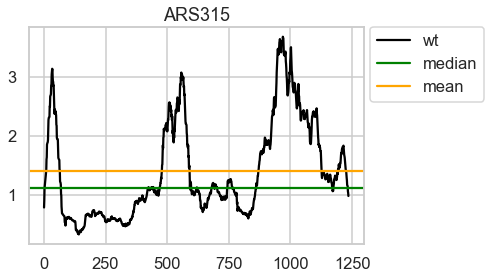

In [108]:
N=40
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [109]:
from scipy import signal

x = pooled_wt_smoothed[0:850]#[470:700]
peaks, properties = signal.find_peaks(x, width=20, 
                               rel_height=0.9,
                               #prominence = (None, 0.8), 
                               height= np.median(x)
                              )
properties

{'peak_heights': array([3.13593388, 0.99589174, 1.13678272, 2.56659943, 3.0717924 ,
        1.20615529, 1.26985703]),
 'prominences': array([2.3445686 , 0.1150804 , 0.14631019, 0.67541587, 2.46607776,
        0.28955879, 0.55565365]),
 'left_bases': array([  0, 141, 141, 141, 141, 644, 644]),
 'right_bases': array([141, 409, 464, 526, 829, 720, 829]),
 'widths': array([ 67.40152854,  24.38279536,  38.9315905 ,  39.84417836,
        254.34289426,  51.43211675, 137.02853124]),
 'width_heights': array([1.02582214, 0.89231937, 1.00510355, 1.95872514, 0.85232241,
        0.94555238, 0.76976874]),
 'left_ips': array([  1.56195726, 384.15001966, 417.06827793, 483.92215749,
        381.07017683, 667.7764073 , 647.73197958]),
 'right_ips': array([ 68.96348579, 408.53281501, 455.99986843, 523.76633585,
        635.41307108, 719.20852405, 784.76051082])}

Text(0.5, 1.0, 'ARS315')

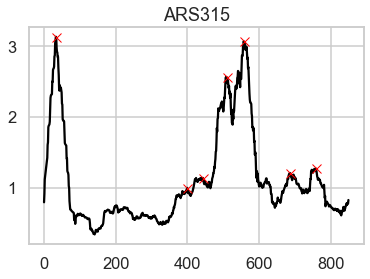

In [110]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "red")
#plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title(load_dir)

In [111]:
print(properties["peak_heights"].mean(axis=0))
print(properties["prominences"].mean(axis=0))

1.9118589253709168
0.941809323750085


## Use scipys peak detection to estimate the size of the nucleosome-free region

In [112]:
N=30
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

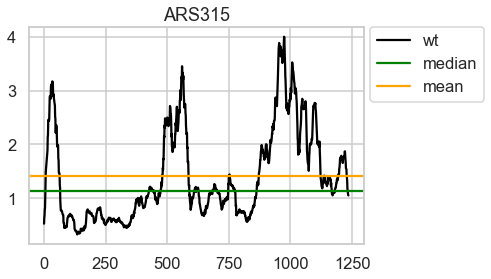

In [113]:
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [115]:
from scipy import signal

x = pooled_wt_smoothed[470:700]
peaks, properties = signal.find_peaks(x, width=30, 
                               #rel_height=0.9,
                              )
properties

{'prominences': array([2.41447887]),
 'left_bases': array([0]),
 'right_bases': array([179]),
 'widths': array([43.93569492]),
 'width_heights': array([2.2433659]),
 'left_ips': array([63.24202]),
 'right_ips': array([107.17771492])}

Text(0.5, 1.0, 'ARS315')

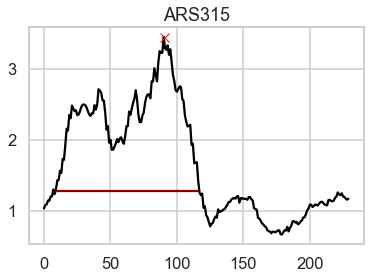

In [117]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title(load_dir)

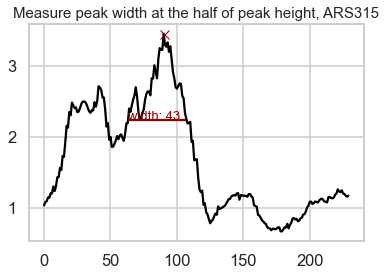

In [118]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
            xmax=properties["right_ips"], color = "darkred")

plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
         fontsize = 13, color="darkred")
plt.title( "Measure peak width at the half of peak height, ARS315", fontsize = 15)

plt.show()

In [119]:
pooled_dies6_smoothed = np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[470:700]
pooled_disw2_smoothed = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[470:700]

#look for a peak and it's properties in the same area for mutant strains:

peaks_dies6, prop_dies6 = signal.find_peaks(pooled_dies6_smoothed, 
                               height = np.mean(pooled_wt_smoothed,axis=0), 
                                     width=30)
peaks_disw2, prop_disw2 = signal.find_peaks(pooled_disw2_smoothed, 
                               height = np.mean(pooled_wt_smoothed,axis=0), 
                                     width=30)

In [120]:
#prop_dies6, prop_disw2, properties

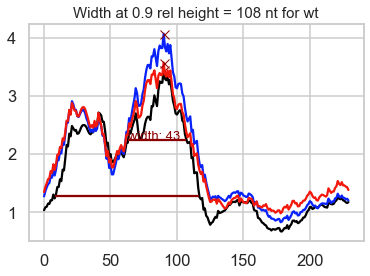

In [121]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
            xmax=properties["right_ips"], color = "darkred")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
         fontsize = 13, color="darkred")

plt.plot(pooled_dies6_smoothed, color = "#0a22fa")
plt.plot(peaks_dies6, pooled_dies6_smoothed[peaks_dies6], "x", color = "darkred")
#plt.hlines(y=prop_dies6["width_heights"], xmin=prop_dies6["left_ips"],
#            xmax=prop_dies6["right_ips"], color = "darkred")

plt.plot(pooled_disw2_smoothed, color = "#f2180c")
plt.plot(peaks_disw2, pooled_disw2_smoothed[peaks_disw2], "x", color = "darkred")
#plt.hlines(y=prop_disw2["width_heights"], xmin=prop_disw2["left_ips"],
#            xmax=prop_disw2["right_ips"], color = "darkred")
plt.title("Width at 0.9 rel height = 108 nt for wt", fontsize = 15)

plt.show()

In [77]:
width = signal.peak_widths(x, peaks, rel_height =0.8)
width

(array([103.98084898]),
 array([1.51902224]),
 array([11.64562205]),
 array([115.62647103]))

In [78]:
peak_indices_dies6 = np.where(pooled_dies6_smoothed > width[1])[0]
width_dies6 = peak_indices_dies6[-1] - peak_indices_dies6[0]
#width_dies6 = 124 - peak_indices_dies6[0]
print("peak width for dies6: ", width_dies6)

peak_indices_disw2 = np.where(pooled_disw2_smoothed > width[1])[0]
width_disw2 = peak_indices_disw2[-1] - peak_indices_disw2[0]
#width_disw2 = 123 - peak_indices_disw2[0]
print("peak width for disw2: ", width_disw2)

peak width for dies6:  116
peak width for disw2:  218


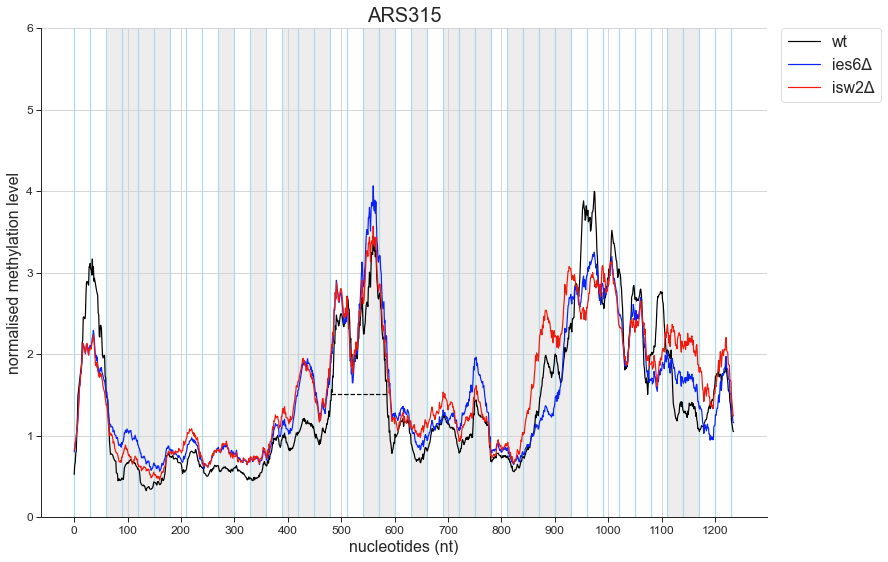

In [79]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        
        #sns.set(font_scale=1.5)
        plt.figure(figsize = (13, 9))
        for left_border in saved.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "lightgray", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlabel("nucleotides (nt)", fontsize = 16)
        plt.ylabel("normalised methylation level", fontsize = 16)
        
        plt.hlines(y=width[1], 
                   xmin=width[2]+470,
                   xmax=width[3]+470, color = "black", linestyles = "dashed")
        
        #plt.savefig(load_dir + "/plots/ARS315_smoothed_profiles_revision_window30_union_selection_peak_width.svg", dpi=300, bbox_inches = "tight")
        plt.show()

## Find valleys in normalised single-molecule data around the origin as footprints of Mcm double hexamers

In [72]:
# https://openwritings.net/pg/python/python-find-peaks-and-valleys-chart-using-scipysignalargrelextrema

In [80]:
#To smoothen the signal in a sliding window across columns, either use pandas rolling in combination with mean, or 
# numpys convolve while applying it along an axis

# df.rolling(30, center=True, axis = 1, closed="both").mean()

smooth_window =30
def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")

In [81]:
# Concatenate normalised data from replicates 
wt_norm = np.concatenate((wt_rep3_maxnorm, wt_rep2_maxnorm), axis = 0)
dies6_norm = np.concatenate((dies6_rep1_maxnorm, dies6_rep2_maxnorm), axis =0)
disw2_norm = np.concatenate((disw2_rep1_maxnorm, disw2_rep2_maxnorm), axis =0)

In [82]:
wt_smooth = np.apply_along_axis(smooth, 1, wt_norm)
dies6_smooth = np.apply_along_axis(smooth, 1, dies6_norm)
disw2_smooth = np.apply_along_axis(smooth, 1, disw2_norm)

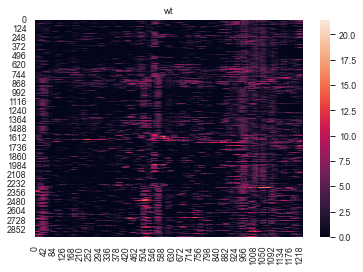

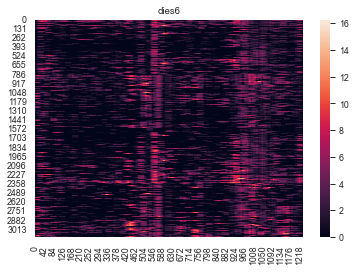

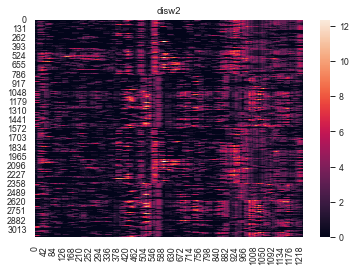

In [83]:
sns.heatmap(wt_smooth)
plt.title("wt")
plt.show()
sns.heatmap(dies6_smooth)
plt.title("dies6")
plt.show()
sns.heatmap(disw2_smooth)
plt.title("disw2")
plt.show()

In [84]:
def measure_valleys(array2D, width_range:tuple = (50,70)):
    #define dataframe to store peak information in 
    peak_sums = pd.DataFrame({"left_bases" : None,
                            "widths" : None} , 
                            index = range(array2D.shape[0]))
    
    for index, row in enumerate(array2D):
        _, peak_array = signal.find_peaks(-row, width= width_range) # only store peaks between 45 and 70 bases
        peak_sums.loc[index, "left_bases"] = list(peak_array["left_bases"])
        peak_sums.loc[index, "widths"] = list(peak_array["widths"])
    return peak_sums

In [85]:
def restore_valleys(peak_summary_df, output_shape:tuple):
    # define array of zeros in output shape, et regions of peaks to one
    zeros_array = np.zeros(output_shape)
    # loop over peak summary dataframe
    for row_num in range(peak_summary_df.shape[0]):
        #check if there are detected peaks for this molecule
        if peak_summary_df.loc[row_num, "widths"]:
            left_pos = peak_summary_df.loc[row_num, "left_bases"]
            widths = peak_summary_df.loc[row_num, "widths"]
            for ind, _ in enumerate(left_pos):
                zeros_array[row_num, left_pos[ind]: (left_pos[ind] + int(widths[ind]))] = 1
                #set stretches for peak width to 1
    return zeros_array

In [95]:
width_range = (50,60)
peaks_wt = measure_valleys(wt_norm, width_range = width_range) #[:,380:800]
rebuild_wt = restore_valleys(peaks_wt, wt_norm.shape) #[:,284:800]

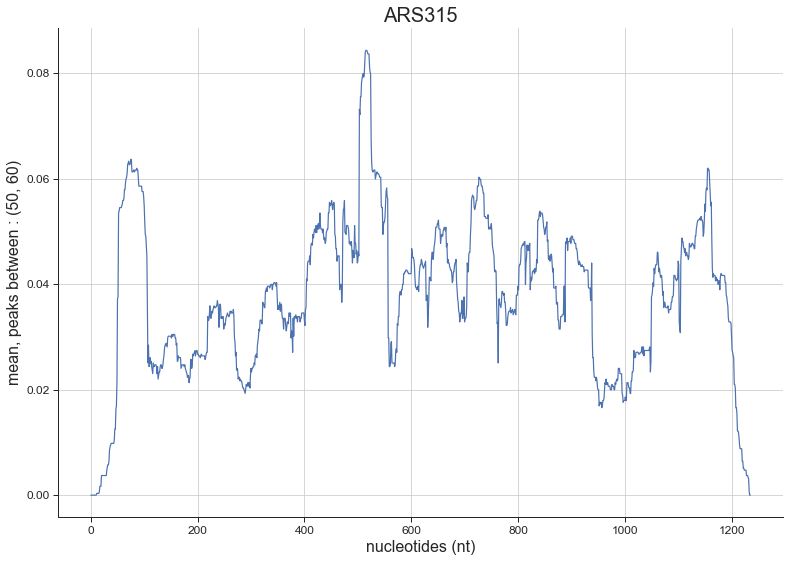

In [96]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.plot(rebuild_wt.mean(axis=0))
        plt.show()

In [97]:
peaks_dies6 = measure_valleys(dies6_norm, width_range = width_range) #[:,380:800]
rebuild_dies6 = restore_valleys(peaks_dies6, dies6_norm.shape) #

peaks_disw2 = measure_valleys(disw2_norm, width_range = width_range) #[:,380:800]
rebuild_disw2 = restore_valleys(peaks_disw2, disw2_norm.shape) #[:,380:800]

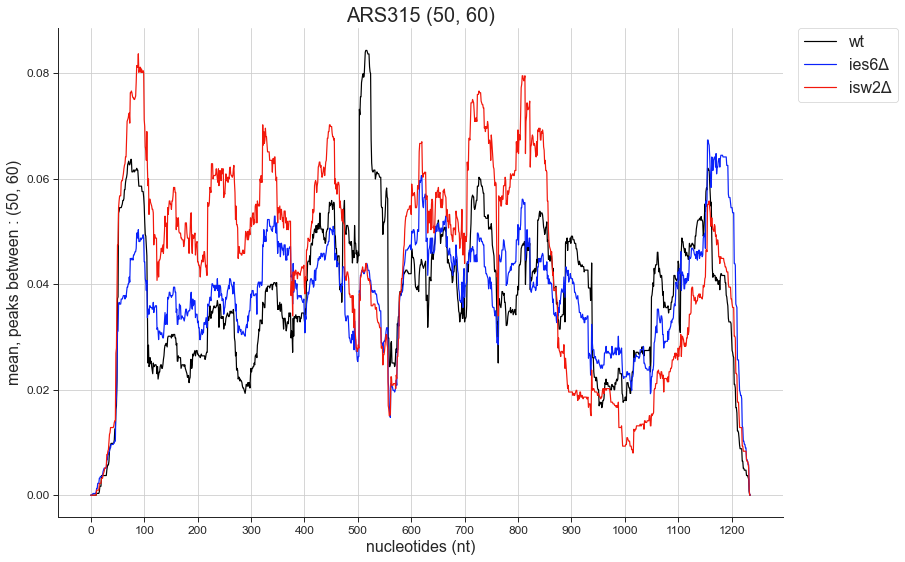

In [98]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        #plt.fill_betweenx((0, 0.09), 405, 788, 
         #             color = "gold", alpha = 0.2)
        sns.lineplot(#x = range(380,800),
            x = range(wt_norm.shape[1]),
             y = rebuild_wt.mean(axis=0),
             color = "black", 
            label = "wt")
        sns.lineplot(#x = range(380, 800),
            x = range(wt_norm.shape[1]),
             y = rebuild_dies6.mean(axis=0), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(#x = range(380, 800),
            x = range(wt_norm.shape[1]),
            y = rebuild_disw2.mean(axis=0), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.xticks(range(0, 1300, 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir +" " + str(width_range), fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        #plt.savefig(load_dir + "/plots/ARS315_distribution_peaks_50_60.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

## Plot the methylation frequency for the whole sequence of the origin:

In [ ]:
#prepare the data:
seq="GTTTTTTCTTTTCAGCACTGCGAAAGAGAGAGCAACGGTAAAGAGCATGAGCCAATTTGAAAAGCAGAAGGAACAGGGCAATTCTTTGTTCAAACAGGGCCTGTATCGCGAGGCTGTGCACTGTTATGACCAACTAATTACTGCTCAACCGCAGAACCCGGTCGGGTACAGCAACAAAGCCATGGCGCTGATCAAACTGGGTGAATATACACAGGCTATTCAAATGTGCCAGCAAGGACTGCGGTACACCTCAACGGCAGAGCATGTAGCTATCAGATCCAAATTGCAATATCGTCTAGAGCTGGCACAGGGAGCGGTAGGTTCAGTACAGATCCCTGTTGTAGAGGTTGATGAACTACCGGAGGGATACGACCGGTCCTGAGAAAAGAGAAAGGGAACACTTCTAATTTATCTTTAAAATTATATATATATATATATATATATGTGTGTTTGTATACTCTGTGGGTATTTCCGTGTATATGGTTAATAATAGTAGTATCTTGTCAGTTTTTTTTATGTTTTTCTTCGCGCGTCAACTTTCTACCAAGAGAAAAACAATATAAGGTCTCCTTACTCTATAGGAGAATAAAACAAACAAAAATAAAAAGCACATCGTAGCGCCAAGAAAATACTGCAAATACCAAATACCACAATAATACTACAATTATCTATACACAAGTGTTTTGCCGCTTAAAACTTCGATTTTCATAGTACGAAACTATACACCCTTGGTTTTTCTCTTTTCTAAATACATATCTACCTTGTAAAGAATTTCCCGCACATCTTTGCGGGCATACAGTTCATGTATTGGCAACTAACGGAACTAAGGCAACATATCTTGCATATTGCAATGTTCACTATATAGATGAAAACTTATATCTAGGTTTCACGACACGAGAATAACTAAGAAGCACGATCCATGATATAGAAAAATCAGTTACGACGAAGCACGGCAAATTAGCCGCCGAAGACCGATATTTTTGCCACCGGTCACAGTTTTCTTTTCCACGGAGCTCTTCGCGGTTTTTTTGTTCCGGATTTTTTTTACCGGCTCTTAGCGGACCGTTTTGGTTATAAGGGGAGTGGCAGCGGCGGTAGACACTGCGCTCTATAAGAATACTTGCAAGGGTCTTGTCTATTGTATAATTCGCTAGTATTTGTTTTGCATTGTACTCTTAATACCCCAACCgggagcttgcatgccggtcgaccacgatttgatgaaagaataacgta"
seq=seq.lower()
#eff_df = pd.DataFrame({"wt_rep3": wt_rep3.mean(axis=0)}, index=range(1236))
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(1236))

eff_df["base"] = [letter for letter in seq]
#eff_df["wt_rep2"] = wt_rep2.mean(axis=0)
#eff_df["dies6_rep1"] = dies6_rep1.mean(axis=0)
#eff_df["dies6_rep2"] = dies6_rep2.mean(axis=0)
#eff_df["disw2_rep1"] = disw2_rep1.mean(axis=0)
#eff_df["disw2_rep2"] = disw2_rep2.mean(axis=0)


eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation after normalisation, ARS315")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_ARS313.tif", dpi=300)

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide after max normalisation")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("normalized frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Normalized methylation over samples")

g

In [ ]:
#Exporting aggregated data for Anna to plot for the manuscript 
#2nd June 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS315_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS315_smooth_30.index = ARS315_smooth_30.index + 1
#ARS315_smooth_30.to_csv("ARS315/ARS315_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, 
                                 mode="same")/np.convolve(pooled_wt, 
                                                          np.ones(smooth_width)/smooth_width, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, 
                                 mode="same")/np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode="same")
}

ARS315_FCs = pd.DataFrame.from_dict(FC)
ARS315_FCs.index = ARS315_FCs.index + 1

#ARS315_FCs.to_csv("ARS315/ARS315_smoothed_fold_changes_winsize_30.csv")